# Exploring African Monsoon Climates with Open Copernicus Data

<!--![title](./CNRS_20060001_0746_Cropped_V2.jpg)-->
![image](https://www.amma2050.org/sites/default/files/styles/ceh_hero/public/CNRS_20060001_0746_Cropped_V2.jpg?itok=ORfmYjWM)

([amma2050.org](https://www.amma2050.org/Home))


In this Notebook, we will use **Earth Observation and Climate Modeling data** provided via [WEkEO](https://www.wekeo.eu/) and the [Copernicus Climate Data Store (CDS)](https://cds.climate.copernicus.eu/#!/home) to learn about **monsoon climates in Africa**, particularly the [West African Monsoon (WAM)](https://www.britannica.com/science/West-African-monsoon).

For this, we will analyze and visualize aspects of global monsoon climate patterns ([Sec. 1](#sec1)), present chracteristics of the WAM ([Sec. 2.1](#sec2.1)), changes in the WAM over the past century ([Sec. 2.2](#sec2.2)) and the correlation of WAM rainfall and wildfire risk in West Africa ([Sec. 2.3](#sec2.3)). 

The utilized **data** include:

 - [ERA5 reanalysis](https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3AREANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS) for monthly mean precipitation and surface wind velocities from 1959 to 2021, plus its [back-extension](https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3AREANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS_PRELIMINARY_BACK_EXTENSION) to 1950 (also see the [first](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview) and [second](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means-preliminary-back-extension) data set in the CDS)
 - [CRU TS](https://crudata.uea.ac.uk/cru/data/hrg/) v4.03 monthly precipitation rates from 1901 to 2020, based on weather station records (see [CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-gridded-observations-global-and-regional?tab=overview))
 - [Fire danger indices](https://www.wekeo.eu/data?view=dataset&dataset=EO%3AECMWF%3ADAT%3ACEMS_FIRE_HISTORICAL) from 1979 to 2021 from the Copernicus Emergency Management Service (see [CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/cems-fire-historical?tab=overview))
 
These presented insights were guided by **scientific literature** (see [Bibliography](#bib)), including the Sixth Assessment Report of the Intergovernmental Panel on Climate Change ([IPCC AR6](https://www.ipcc.ch/report/sixth-assessment-report-working-group-i/)).







 

# Load modules

In [1]:
### Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr
import xesmf

### Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean

### System tools
import os
import sys
import glob
import json
from zipfile import ZipFile
import time
import base64
from IPython.core.display import HTML
import wget
import gzip
import shutil
import datetime
import tarfile

### WEkEO HDA client (correct formatting of .hdarc: https://www.wekeo.eu/docs/hda-python-lib)
from hda import Client
c = Client(debug=False)

### Copernicus Climate Data Store API Client
import cdsapi
c_cds = cdsapi.Client()

# import requests
# import warnings
# warnings.filterwarnings('ignore')

import logging
# logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
logging.getLogger('matplotlib.font_manager').disabled = True

# Retrieve Data from WEkEO and Copernicus CDS



Here, we download and pre-process the necessary data from WEkEO and CDS. 
The pre-processing only consists of regridding onto a coarser 1°x1° horizontal grid to reduce file sizes and processing time.

This retrieval can be skipped by using the prepared NetCDF-files from the accompanying GitHub repository. In this case we can proceed to [Sec. 1](#sec1).

In [ ]:
### Download monthly average ERA5 global precipitation data from 2000 to 2021 from WEkE0 (for Sec. 1)

### Define WEkEO API request
climvar='total_precipitation'
data ={ "datasetId": "EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS",
  "multiStringSelectValues": [
    { "name": "product_type", "value": [ "monthly_averaged_reanalysis" ] },
    { "name": "year", "value": list(np.arange(2000,2021+1,1).astype(str))},
    { "name": "time", "value": [ "00:00" ] },
    { "name": "variable", "value": [ "{}".format(climvar) ] },
    { "name": "month", "value": [ "10", "11", "12", "01", "02", "03", "04", "05", "06", "07", "08", "09" ] } ],
  "stringChoiceValues": [ { "name": "format", "value": "netcdf" } ] }

### Download the Data
matches = c.search(data)
print(matches)
matches.download()

ncfiles_sorted = sorted(filter(os.path.isfile, glob.glob('adaptor*.nc')), key=os.path.getmtime)
os.rename(ncfiles_sorted[0],'./data/ERA5_orig/ERA5_2000-2021_{}_global.nc'.format(climvar))

In [ ]:
### Download monthly average ERA5 climate data for Africa from 1959 to 2021 from WEkE0 (for Sec. 2.1)

climvars=['total_precipitation','10m_u_component_of_wind','10m_v_component_of_wind']
for climvar in climvars:
    data ={ "datasetId": "EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS",
      "boundingBoxValues": [ { "name": "area", "bbox": [ -50, -50, 90, 60 ] } ],
      "multiStringSelectValues": [
        { "name": "product_type",
          "value": [ "monthly_averaged_reanalysis" ] },
        { "name": "year",
          "value": list(np.arange(1959,2021+1,1).astype(str))},
        { "name": "time", "value": [ "00:00" ] },
        { "name": "variable", "value": [ "{}".format(climvar) ] },
        { "name": "month", "value": [ "10", "11", "12", "01", "02", "03", "04", "05", "06", "07", "08", "09" ] } ],
      "stringChoiceValues": [ { "name": "format", "value": "netcdf" } ] }

    matches = c.search(data)
    print(matches)
    matches.download()

    ncfiles_sorted = sorted(filter(os.path.isfile, glob.glob('adaptor*.nc')), key=os.path.getmtime)
    os.rename(ncfiles_sorted[0],'./data/ERA5_orig/ERA5_1959-2021_{}.nc'.format(climvar))

In [ ]:
### Download monthly average ERA5 precipitation data for Africa from 1950 to 1978 from WEkE0 (for Sec. 2.2)

climvar='total_precipitation'
data ={"datasetId": "EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS_PRELIMINARY_BACK_EXTENSION",
  "boundingBoxValues": [ { "name": "area", "bbox": [ -50, -50, 90, 60 ] } ],
  "multiStringSelectValues": [
    { "name": "product_type", "value": [ "reanalysis-monthly-means-of-daily-means" ] },
    { "name": "variable", "value": [ "{}".format(climvar) ] }, {
      "name": "year", "value": list(np.arange(1950,1978+1,1).astype(str)) },
    { "name": "month", "value": [ "10", "11", "12", "01", "02", "03", "04", "05", "06", "07", "08", "09" ] },
    { "name": "time", "value": [ "00:00" ] } ],
  "stringChoiceValues": [ { "name": "format", "value": "netcdf" } ] }

matches = c.search(data)
print(matches)
matches.download()

ncfiles_sorted = sorted(filter(os.path.isfile, glob.glob('adaptor*.nc')), key=os.path.getmtime)
os.rename(ncfiles_sorted[0],'./data/ERA5_orig/ERA5_1950-1978_{}.nc'.format(climvar))  

In [ ]:
### Download ERA5 global land-sea mask from WEkE0 (for Sections 2.2-2.3)

data ={ "datasetId": "EO:ECMWF:DAT:REANALYSIS_ERA5_SINGLE_LEVELS_MONTHLY_MEANS",
  "multiStringSelectValues": [
    {"name": "variable", "value": [ "land_sea_mask" ]}, 
    {"name": "year", "value": [ "2021" ]},
    {"name": "month", "value": [ "01" ]},
    {"name": "time", "value": [ "00:00" ]},
    {"name": "product_type", "value": [ "monthly_averaged_reanalysis" ]} ],
  "stringChoiceValues": [ {"name": "format", "value": "netcdf"} ] }

matches = c.search(data)
print(matches)
matches.download()

ncfiles_sorted = sorted(filter(os.path.isfile, glob.glob('adaptor*.nc')), key=os.path.getmtime)
os.rename(ncfiles_sorted[0], './data/ERA5_land-sea-mask.nc')

In [24]:
### Regrid higher resolution ERA5 data to 1°x1° grid to reduce data size

ERA5_files_orig = ['ERA5_1959-2021'] #['ERA5_1950-1978_total_precipitation','ERA5_1959-2021','ERA5_2000-2021_total_precipitation_global']

for filename in ERA5_files_orig:
    #filename=os.path.splitext(ERA5_file)[0]
    if filename=='ERA5_1959-2021':
        ds=xr.open_mfdataset(glob.glob('./data/ERA5_orig/ERA5_1959-2021_*.nc')) # merge multiple ERA5 variables into one NetCDF file
        ds=ds.assign(tp=ds.tp*1000) # convert units #,t2m=ds_era.t2m-273.15
    else:
        ds=xr.open_dataset('./data/ERA5_orig/{}.nc'.format(filename))    
    
    dlat=dlon=1;
    xesmf_1deg_grid = xr.Dataset({'latitude': (['latitude'], np.arange(np.around(ds.latitude.min().values)+0.5*dlat,np.around(ds.latitude.max().values)-0.5*dlat+dlat,dlat)),
                                  'longitude': (['longitude'], np.arange(np.around(ds.longitude.min().values)+0.5*dlon,np.around(ds.longitude.max().values)-0.5*dlon+dlon,dlon))})
    regridder = xesmf.Regridder(ds, xesmf_1deg_grid, method='bilinear', periodic=True)
    
    ds_1deg = regridder(ds) 
    ds.close()

    if filename=='ERA5_1950-1978_total_precipitation': 
        ds_1deg.to_netcdf('./data/{}_1deg.nc'.format(filename),encoding={'tp':{'zlib': True,'complevel': 7}})   
    elif filename=='ERA5_1959-2021':
        ds_1deg.sel(time=ds_1deg.time.dt.year.isin(np.arange(2000,2021+1,1))).to_netcdf('./data/ERA5_2000-2021.nc', 
                    encoding={'tp':{'zlib': True,'complevel': 7},'u10':{'zlib': True,'complevel': 7},'v10':{'zlib': True,'complevel': 7}}) #.drop(['t2m'])
        ds_1deg.drop(['u10','v10']).to_netcdf('./data/ERA5_1959-2021.nc', encoding={'tp':{'zlib': True,'complevel': 7}}) #.drop(['t2m','u10','v10'])
    elif filename=='ERA5_2000-2021_total_precipitation_global':
        ds_1deg.to_netcdf('./data/{}_1deg.nc'.format(filename),encoding={'tp':{'zlib': True,'complevel': 7}})                                                               
    else:                                                                    
        try:
            os.remove('./data/{}_1deg.nc'.format(filename))
        except OSError:
            pass
        ds_1deg.to_netcdf(filename+'_1deg.nc')

In [2]:
### Download CRU TS v4.03 global precipitation data from 1901 to 2019 from the Copernicus CDS 

### Define CDS API request
c_cds.retrieve( 'insitu-gridded-observations-global-and-regional', {
        'format': 'tgz',
        'origin': 'cru',
        'variable': 'precipitation',
        'time_aggregation': 'monthly',
        'horizontal_aggregation': '1_x_1',
        'version': 'v4.03',
        'region': 'global',
        'year': list(np.arange(1901,2019+1,1).astype(str)),} 
    './data/CRU-TS_CDS.tar.gz')

file = tarfile.open('./data/CRU-TS_CDS.tar.gz')
file.extractall('./data/CRU-TS_CDS')
file.close()

In [4]:
### Merge CRU TS files and select only a box covering Africa
ds_cru=xr.open_mfdataset(glob.glob('./data/CRU-TS_CDS/CRU_*.nc'))
ds_cru=ds_cru.sel(lat=slice(-50,60),lon=slice(-50,90))
ds_cru.to_netcdf('./data/CRU-TS4p03_PRC_1901-2019.nc', encoding={'pr':{'zlib': True,'complevel': 7}}) 

In [ ]:
### Download global Fire Danger Index data from 1980 to 2021 from WEkEO
### Note: We only download day 15 of the months instead of all days to calculate monthly means.

day=15
data={ "datasetId": "EO:ECMWF:DAT:CEMS_FIRE_HISTORICAL",
  "multiStringSelectValues": [
    { "name": "product_type", "value": [ "reanalysis" ] },
    { "name": "variable", "value": [ "fire_danger_index" ] },
    { "name": "version", "value": [ "4.0" ] },
    { "name": "dataset", "value": [ "Consolidated dataset" ] },
    { "name": "year", "value": list(np.arange(1980,2021+1,1).astype(str)) },
    { "name": "month", "value": [ "01", "02", "03", "04", "05", "06", "07", "08", "09","10", "11", "12" ] },
    { "name": "day", "value": ['{:02}'.format(day)] } ],
  "stringChoiceValues": [ { "name": "format", "value": "tgz" } ] }

matches = c.search(data)
print(matches)
matches.download()

ncfiles_sorted = sorted(filter(os.path.isfile, glob.glob('dataset-cems-fire-historical-*.tar.gz')), key=os.path.getmtime)
os.rename(ncfiles_sorted[0], './data/dataset-cems-fire-historical_1980-1921_day{}.tar.gz'.format(day))

file = tarfile.open('./data/dataset-cems-fire-historical_1980-1921_day{}.tar.gz')
file.extractall('./data/fire_danger')
file.close()

In [42]:
### Merge and regrid Fire Danger Index data
ds_fire=xr.open_mfdataset(glob.glob('./data/fire_danger/ECMWF_MARK5_FDI_*15_1200_hr_v4.0_con.nc'))
ds_fire=ds_fire.roll(longitude=int(ds_fire.longitude.shape[0]/2),roll_coords=False)
ds_fire=ds_fire.assign_coords({'longitude':('longitude',ds_fire.longitude.values-180,ds_fire.longitude.attrs)})

dlat=dlon=1;
xesmf_1deg_grid = xr.Dataset({'latitude': (['latitude'], np.arange(np.around(ds_fire.latitude.min().values)+0.5*dlat,np.around(ds_fire.latitude.max().values)-0.5*dlat+dlat,dlat)),
                              'longitude': (['longitude'], np.arange(np.around(ds_fire.longitude.min().values)+0.5*dlon,np.around(ds_fire.longitude.max().values)-0.5*dlon+dlon,dlon))})
regridder = xesmf.Regridder(ds_fire, xesmf_1deg_grid, method='bilinear', periodic=True)
ds_fire_1deg = regridder(ds_fire) 
ds_fire_1deg=ds_fire_1deg.sel(latitude=slice(-50,60),longitude=slice(-50,90))

ds_fire_1deg.to_netcdf('./data/fire_danger_1980-2021.nc', encoding={'fdi':{'zlib': True,'complevel': 7}})

#  1. The Global Monsoon <a name="sec1"></a>

In the following, we use precipitation fields from the ERA5 climate reanalysis data to illustrate the global monsoon in the present climate state. 

In [4]:
### Load the pre-processed ERA5 data (global monthly precipitation rates from 2000 to 2021 on a 1°x1° horizontal grid)
ds_era_global = xr.open_dataset('./data/ERA5_2000-2021_total_precipitation_global_1deg.nc')

### Shift longitude and data
ds_era_global=ds_era_global.assign_coords({'longitude':('longitude',ds_era_global.longitude.data-180,ds_era_global.longitude.attrs)})
ds_era_global=ds_era_global.roll(longitude=int(ds_era_global.longitude.shape[0]/2),roll_coords=False)

### Precipitation rates from m/day to mm/day                                    
ds_era_global=ds_era_global.assign(tp=ds_era_global.tp*1000)

### Average over 2000-2021 to obtain reference climate state
ds_era_global_ref=ds_era_global.groupby('time.month').mean(dim='time')

Monsoons represent the major climatic mode of the annual variation of rainfall and atmospheric circulation in the tropics and subtropics [8].
They are generally expressed by pronounced wet and dry seasons and a seasonal reversal of the dominant wind directions.

Monsoonal conditions are often defined based on simple criteria for the annual distribution of rainfall (e.g. [10]). Here, we adopt the simple definition, that the difference between the local summer and winter precipitation rate should be greater than 2.5 mm/day [4,11].

In [5]:
### Calculate the seasonal mean precipitation, here for May-September (MJJAS) and November-March (NDJFM)
ds_MJJAS=ds_era_global_ref.isel(month=np.arange(4,8+1,1)).mean(dim='month')
ds_NDJFM=ds_era_global_ref.isel(month=[10,11,0,1,2]).mean(dim='month')

### Set the minimum seasonal precipitation difference for a monsoonal climate to 2.5 mm/day
PRC_monsoon_crit=2.5

### Determine where the monsoon condition is fulfilled on the northern/southern hemisphere
condi_monsoon_NH=((((ds_MJJAS.tp-ds_NDJFM.tp)>=PRC_monsoon_crit).where(ds_era_global_ref.latitude>=0))==1)
condi_monsoon_SH=((((ds_MJJAS.tp-ds_NDJFM.tp)<=-PRC_monsoon_crit).where(ds_era_global_ref.latitude<=0))==1)

Now we can plot the obtained monsoon domains in the present climate state on a map, together with the seasonal precipitation rates.

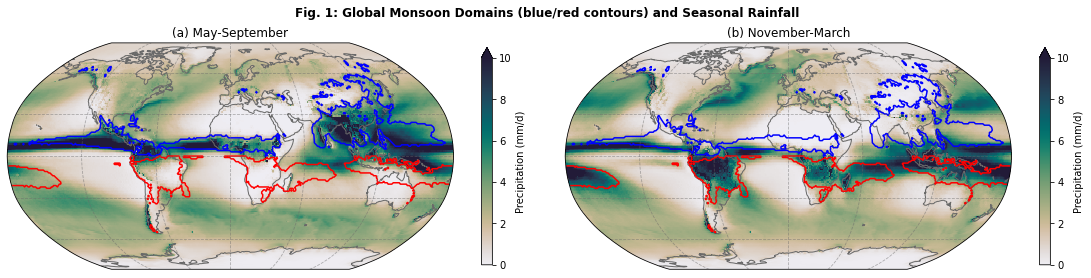

In [6]:
fig,axs=plt.subplots(1,2,subplot_kw={'projection': ccrs.Robinson()},figsize=(20,10),facecolor='w')

p0=ds_MJJAS.tp.plot(ax=axs[0],cmap=cmocean.cm.rain,vmin=0,vmax=10,transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.4,'label': 'Precipitation (mm/d)'})
p1=ds_NDJFM.tp.plot(ax=axs[1],cmap=cmocean.cm.rain,vmin=0,vmax=10,transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.4,'label': 'Precipitation (mm/d)'})

for aa in axs:
    aa.coastlines(color='dimgrey')
    condi_monsoon_NH.plot.contour(ax=aa,transform=ccrs.PlateCarree(),colors='b',levels=[0.5])
    condi_monsoon_SH.plot.contour(ax=aa,transform=ccrs.PlateCarree(),colors='r',levels=[0.5])
 
for pp in [p0,p1]:
    pp.axes.gridlines(color='dimgrey', alpha=0.5, linestyle='--') 
    
axs[0].set_title('(a) May-September')
axs[1].set_title('(b) November-March')
fig.suptitle('Fig. 1: Global Monsoon Domains (blue/red contours) and Seasonal Rainfall',fontweight='bold',y=0.71)
    
fig.subplots_adjust(wspace=0)

We can see that several monsoon regions can be identified in North and South America, in Africa, Asia and the Australian-Maritime Continent [4].

In Africa, the West African Monsoon represents the most prominent and well-defined monsoon domain ([Sec. 2](#sec2)). However, also Eastern and Southern African climate can be characterized in terms of monsoons (e.g. [2,12]).

# 2. The West African Monsoon (WAM) <a name="sec2"></a>

## 2.1 Present State of the WAM <a name="sec2.1"></a>

In this section, we will briefly study the present characteristics of the West African Monsoon (WAM). Its domain covers West Africa from  ca. 3°N to 20°N, from the Guinean coast to the Sahel. 

In [2]:
### Load ERA5 data for Africa (monthly precipitation and surface wind velocities for 2000 to 2021 on a 1°x1° horizontal grid, 50°W-90°E and 50°N-50°S)
ds_era_present=xr.open_dataset('./data/ERA5_2000-2021.nc')

### Average to obtain present-day reference climate conditions
ds_era_ref=ds_era_present.groupby('time.month').mean(dim='time')

### Define two regional boxes for the Sahel and Guinea Coast. 
### With these, we can assess the regional expression of the WAM below.
bounds_GuineaCoast=[3,6,-12,6] # lat0,lat1,lon0,lon1
bounds_Sahel=[12,15,-12,6]

We will now plot maps of West African precipitation and wind fields for selected months to illustrate the seasonal weather cycle that makes up the West African Monsoon.

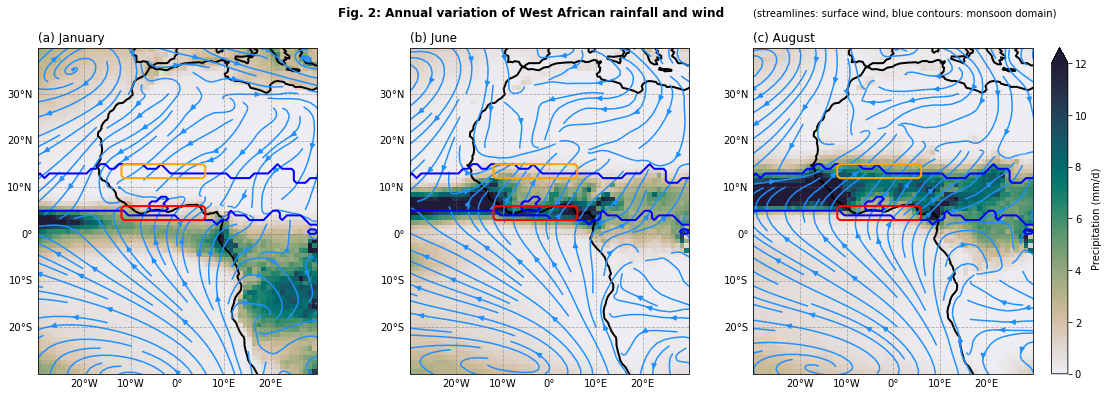

In [11]:
fig,axs=plt.subplots(1,3,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(20,6),facecolor='w')

### Plot precipitation rates for January, June and August
p0=ds_era_ref.isel(month=0).tp.plot.pcolormesh(ax=axs[0],cmap=cmocean.cm.rain,vmin=0,vmax=12,transform=ccrs.PlateCarree(), add_colorbar=False)
p1=ds_era_ref.isel(month=5).tp.plot.pcolormesh(ax=axs[1],cmap=cmocean.cm.rain,vmin=0,vmax=12,transform=ccrs.PlateCarree(), add_colorbar=False)
p2=ds_era_ref.isel(month=7).tp.plot.pcolormesh(ax=axs[2],cmap=cmocean.cm.rain,vmin=0,vmax=12,transform=ccrs.PlateCarree(), cbar_kwargs={'label': 'Precipitation (mm/d)'})

### Plot surface wind directions for January, June and August as streamline maps
for idx,month in enumerate([0,5,7]):
    ds_era_ref.isel(month=month).plot.streamplot(x='longitude',y='latitude',u='u10',v='v10',ax=axs[idx],density=2,color='dodgerblue')
### Alternatively, plot the wind velocities as vectors:
# skip = 2 
# for idx,month in enumerate([0,5,7]):
#     axs[idx].quiver(ds_era_ref.longitude[::skip],ds_era_ref.latitude[::skip],ds_era_ref.isel(month=month).u10[::skip,::skip],ds_era_ref.isel(month=month).v10[::skip,::skip],scale=1e2)

mask_GuineaCoast=xr.where((ds_era_ref.latitude>=bounds_GuineaCoast[0]) & (ds_era_ref.latitude<=bounds_GuineaCoast[1]) & 
                          (ds_era_ref.longitude>=bounds_GuineaCoast[2]) & (ds_era_ref.longitude<=bounds_GuineaCoast[3]),1,0)
mask_Sahel=xr.where((ds_era_ref.latitude>=bounds_Sahel[0]) & (ds_era_ref.latitude<=bounds_Sahel[1]) & 
                    (ds_era_ref.longitude>=bounds_Sahel[2]) & (ds_era_ref.longitude<=bounds_Sahel[3]),1,0)

for aa in axs:
    aa.set_extent([-30, 30, -30, 40], crs=ccrs.PlateCarree())
    aa.coastlines(color='k',linewidth=2)
    #aa.add_feature(cf.BORDERS,edgecolor='dimgrey',linewidth=1.5)
    
    ### Plot the monsoon region outlines from Sec. 1  again (as blue contours)
    condi_monsoon_NH.plot.contour(ax=aa,transform=ccrs.PlateCarree(),colors='b',levels=[0.5],linewidths=2)
    
    ### Draw the two regional boxes
    mask_GuineaCoast.plot.contour(ax=aa,transform=ccrs.PlateCarree(),colors='r',levels=[0.5],linewidths=2)
    mask_Sahel.plot.contour(ax=aa,transform=ccrs.PlateCarree(),colors='orange',levels=[0.5],linewidths=2)    
    
for pp in [p0,p1,p2]:
    gl=pp.axes.gridlines(color='dimgrey', alpha=0.5, linestyle='--',crs=ccrs.PlateCarree(), draw_labels=True)    
    gl.top_labels = False
    gl.right_labels = False
    
fig.suptitle('Fig. 2: Annual variation of West African rainfall and wind',fontweight='bold',y=0.975)
axs[0].set_title('(a) January',loc='left')
axs[1].set_title('(b) June',loc='left')
axs[2].set_title('(c) August',loc='left')
axs[2].text(0.0,1.09,'(streamlines: surface wind, blue contours: monsoon domain)',transform=axs[2].transAxes,va='bottom')

fig.subplots_adjust(wspace=0)

fig.savefig('Figure-02_WestAfricanMonsoon.jpg', bbox_inches='tight', dpi=300)

Before discussing the seasonal WAM cycle, we add another figure that shows the latitudinal shift of West Africa precipitation over all months. </br>
Additionally, we will plot the monthly rainfall rates in the two regional boxes in the above maps.

Text(0.5, 0.975, 'Fig. 3: Annual variation of West African rainfall as a zonal mean (a) and in two regions (b)')

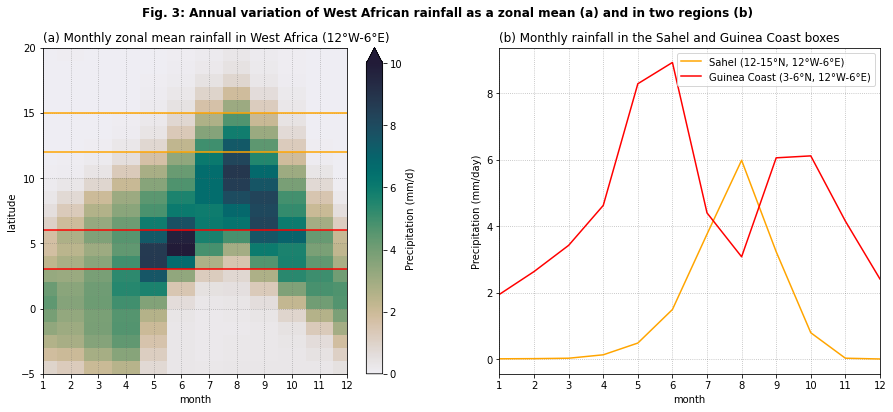

In [29]:
fig,axs=plt.subplots(1,2,figsize=(15,6),facecolor='w')

weights_lat=np.cos(np.deg2rad(ds_era_ref.latitude))

ds_era_ref.where((mask_Sahel)).tp.weighted(weights_lat).mean(dim=['latitude','longitude']).plot(c='orange',ax=axs[1],label='Sahel (12-15°N, 12°W-6°E)')
ds_era_ref.where(mask_GuineaCoast).tp.weighted(weights_lat).mean(dim=['latitude','longitude']).plot(c='r',ax=axs[1],label='Guinea Coast (3-6°N, 12°W-6°E)') #.where(landseamask)

prc_zonalmean=ds_era_ref.where((ds_era_ref.longitude>=-12) & (ds_era_ref.longitude<=6)).tp.weighted(weights_lat).mean(dim='longitude')
prc_zonalmean.plot(x='month',y='latitude',ylim=[-5,20],cmap=cmocean.cm.rain,vmin=0,vmax=10,ax=axs[0], cbar_kwargs={'label': 'Precipitation (mm/d)'})

axs[1].legend()

axs[0].axhline(y=bounds_GuineaCoast[0],c='r')
axs[0].axhline(y=bounds_GuineaCoast[1],c='r')
axs[0].axhline(y=bounds_Sahel[0],c='orange')
axs[0].axhline(y=bounds_Sahel[1],c='orange')

axs[1].set_ylabel('Precipitation (mm/day)')

for aa in axs:
    aa.set_xlim([1,12])
    aa.set_xticks(range(1,12+1));
    aa.grid(color='dimgrey', alpha=0.5, linestyle=':')
    
axs[1].set_title('(b) Monthly rainfall in the Sahel and Guinea Coast boxes',loc='left')
axs[0].set_title('(a) Monthly zonal mean rainfall in West Africa (12°W-6°E)',loc='left')
fig.suptitle('Fig. 3: Annual variation of West African rainfall as a zonal mean (a) and in two regions (b)',fontweight='bold',y=0.975)

Figures 2 and 3 illustrate seasonal and geographic characteristics of the West African Monsoon. 

The WAM is characterized by a northward progression of rainfall approximately from April to September (Fig. 3a). Moist low-level south-westerlies from the Gulf of Guinea bring abundant rainfall which remains along the Guinean Coast during May and June, with a maximum near 5°N (Figs. 2b, 3) [8].

This is followed by a sudden decrease of rainfall, marking the 'short dry season' in the Guinean Coast around August (Fig. 3). At the same time it is the onset of the monsoon in the Sahel, as the precipitation belt progresses to beyond 10°N with a peak in August-September (Figs. 2c, 3) [8].

The monsoon then retreats southward and causes second precipitation maximum at the Guinean coast around October [8]. November to March mark the dry season with prevailing north easterly winds from the Sahara ("Harmattan").

## 2.2 Long-term Changes in the WAM <a name="sec2.2"></a>

The reconstructed summer precipitation rates (June-August-September) in the ERA5 reanalysis and CRU TS weather station data sets will inform us in the following, if and how the described African Monsoon pattern varied during past decades.

In [2]:
### Load the CRU TS v4.03 monthly precipitation data (for Africa from 1901 to 2019 on a 1°x1° horizontal grid)
ds_cru=xr.open_dataset('./data/CRU-TS4p03_PRC_1901-2019.nc')
ds_cru=ds_cru.assign(pr=ds_cru.pr*1/30) # convert precipitation rates from mm/month to mm/day

### Load the ERA5 monthly precipitation data (for Africa from 1959 to 2021 on a 1°x1° horizontal grid)
ds_era=xr.open_dataset('./data/ERA5_1959-2021.nc')
### Load the ERA5 monthly precipitation data back-extended to 1950
ds_era_extd=xr.open_dataset('./data/ERA5_1950-1978_total_precipitation_1deg.nc')
ds_era_extd=ds_era_extd.assign(tp=ds_era_extd.tp*1000)

### Load land-sea mask from ERA5 data so that we can extract rainfall over continents only
ds_era_landseamask = xr.open_dataset('./data/ERA5_land-sea-mask.nc')
ds_era_landseamask=ds_era_landseamask.roll(longitude=int(ds_era_landseamask.longitude.shape[0]/2),roll_coords=False)
ds_era_landseamask=ds_era_landseamask.assign_coords({'longitude':('longitude',ds_era_landseamask.longitude.values-180,ds_era_landseamask.longitude.attrs)})
mask_landsea=ds_era_landseamask.lsm.isel(time=0)

### Define regional box for the West African Sahel as in IPCC AR6 [5]
bounds_Sahel_IPCC=[10,20,-20,30] # lat0,lat1,lon0,lon1

We will now plot maps of African summer monsoon (JAS) changes from the 1950s to the 1980s and the years 2010-2020 as expressed by the ERA5 and CRU TS data sets.

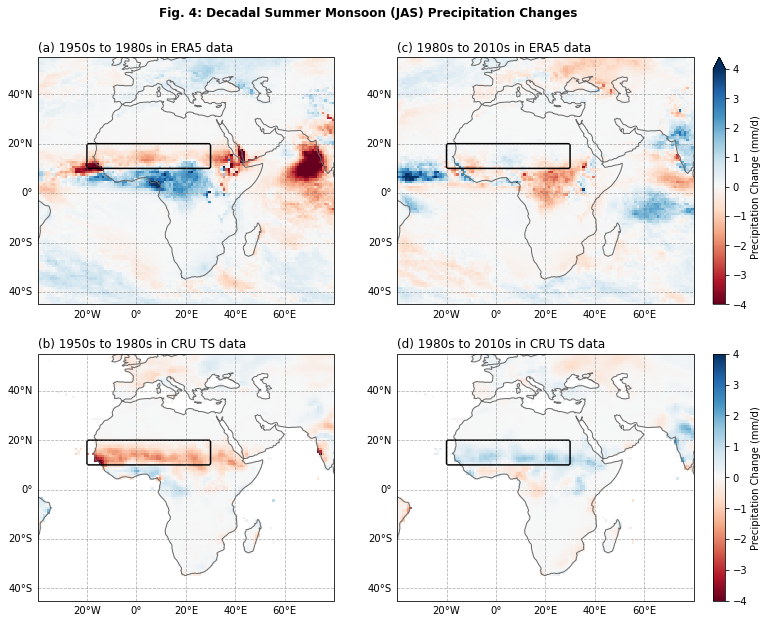

In [3]:
mask_Sahel_IPCC_era=xr.where((ds_era.latitude>=bounds_Sahel_IPCC[0]) & (ds_era.latitude<=bounds_Sahel_IPCC[1]) 
                         & (ds_era.longitude>=bounds_Sahel_IPCC[2]) & (ds_era.longitude<=bounds_Sahel_IPCC[3]),1,0)
mask_Sahel_IPCC_cru=xr.where((ds_cru.lat>=bounds_Sahel_IPCC[0]) & (ds_cru.lat<=bounds_Sahel_IPCC[1]) 
                         & (ds_cru.lon>=bounds_Sahel_IPCC[2]) & (ds_cru.lon<=bounds_Sahel_IPCC[3]),1,0)

### Calculate July-August-September mean precipitation rates from ERA5 and CRU TS data
prc_JAS_era=ds_era.tp.isel(time=ds_era.time.dt.month.isin([6,7,8])).groupby('time.year').mean(dim='time')
prc_JAS_era_extd=ds_era_extd.tp.isel(time=ds_era_extd.time.dt.month.isin([6,7,8])).groupby('time.year').mean(dim='time')
prc_JAS_cru=ds_cru.pr.isel(time=ds_cru.time.dt.month.isin([6,7,8])).groupby('time.year').mean(dim='time')

### Average over the 1950s and 1980s
prc_JAS_era_1950s=prc_JAS_era_extd.sel(year=slice(1950,1960)).mean(dim='year')
prc_JAS_era_1980s=prc_JAS_era.sel(year=slice(1980,1990)).mean(dim='year')
prc_JAS_era_2010s=prc_JAS_era.sel(year=slice(2010,2020)).mean(dim='year')
prc_JAS_cru_1950s=prc_JAS_cru.sel(year=slice(1950,1960)).mean(dim='year')
prc_JAS_cru_1980s=prc_JAS_cru.sel(year=slice(1980,1990)).mean(dim='year')
prc_JAS_cru_2010s=prc_JAS_cru.sel(year=slice(2010,2020)).mean(dim='year') # data only until 2019 though

### Calculate the summer precipitation change from the 1950s to the 1980s
prc_JAS_era_diff_1950to1980s=prc_JAS_era_1980s-prc_JAS_era_1950s
prc_JAS_cru_diff_1950to1980s=prc_JAS_cru_1980s-prc_JAS_cru_1950s
prc_JAS_era_diff_1980to2010s=prc_JAS_era_2010s-prc_JAS_era_1980s
prc_JAS_cru_diff_1980to2010s=prc_JAS_cru_2010s-prc_JAS_cru_1980s

### Plot Maps of the decadal precipitation changes
fig,axs=plt.subplots(2,2,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(14,10),facecolor='w')
axs_list=axs.flatten()

p0=prc_JAS_era_diff_1950to1980s.plot(cmap='RdBu',vmin=-4,vmax=4,ax=axs[0,0],add_colorbar=False)
p1=prc_JAS_cru_diff_1950to1980s.plot(cmap='RdBu',vmin=-4,vmax=4,ax=axs[1,0],add_colorbar=False)

p2=prc_JAS_era_diff_1980to2010s.plot(cmap='RdBu',vmin=-4,vmax=4,ax=axs[0,1], cbar_kwargs={'label': 'Precipitation Change (mm/d)'})
p3=prc_JAS_cru_diff_1980to2010s.plot(cmap='RdBu',vmin=-4,vmax=4,ax=axs[1,1], cbar_kwargs={'label': 'Precipitation Change (mm/d)'})

for aa in axs_list:
    aa.coastlines(color='dimgrey')
    mask_Sahel_IPCC_era.plot.contour(ax=aa,transform=ccrs.PlateCarree(),colors='k',levels=[0.5])
    aa.set_extent([-40, 80, -45, 55], crs=ccrs.PlateCarree())
    
for pp in [p0,p1,p2,p3]:
    gl=pp.axes.gridlines(color='dimgrey', alpha=0.5, linestyle='--',crs=ccrs.PlateCarree(), draw_labels=True)    
    gl.top_labels = False
    gl.right_labels = False
    
axs[0,0].set_title('(a) 1950s to 1980s in ERA5 data',loc='left')
axs[0,1].set_title('(c) 1980s to 2010s in ERA5 data',loc='left')
axs[1,0].set_title('(b) 1950s to 1980s in CRU TS data',loc='left')
axs[1,1].set_title('(d) 1980s to 2010s in CRU TS data',loc='left')
fig.suptitle('Fig. 4: Decadal Summer Monsoon (JAS) Precipitation Changes',y=0.95,fontweight='bold')

fig.subplots_adjust(wspace=0)

Before discussing the displayed patterns of West African summer monsoon precipitation, we will additionally plot the JAS precipitation timeseries for the Sahel region box in the maps of Fig. 4. </br>
In this, we are following the assessments of the IPCC AR6 [4,6].

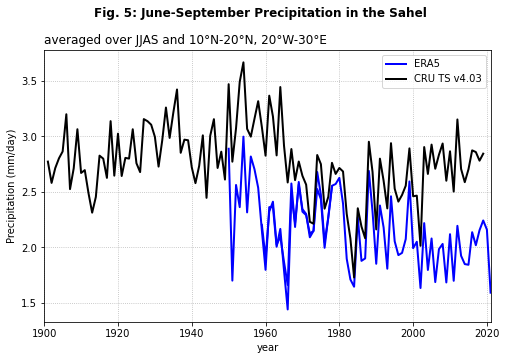

In [4]:
### Calculate June-August-September mean precipitation rates from ERA5 and CRU TS data
prc_JJAS_era=ds_era.tp.sel(time=ds_era.time.dt.month.isin([5,6,7,8])).groupby('time.year').mean(dim='time')
prc_JJAS_era_extd=ds_era_extd.tp.sel(time=ds_era_extd.time.dt.month.isin([5,6,7,8])).groupby('time.year').mean(dim='time')
prc_JJAS_cru=ds_cru.pr.sel(time=ds_cru.time.dt.month.isin([5,6,7,8])).groupby('time.year').mean(dim='time')

### Sahel summer (JJAS) precipitation in ERA5 reanalysis (1979-2020)

weights_lat_era=np.cos(np.deg2rad(ds_era.latitude))
weights_lat_cru=np.cos(np.deg2rad(ds_cru.lat))

prc_JJAS_era_Sahel=prc_JJAS_era.where(mask_Sahel_IPCC_era).where(mask_landsea).weighted(weights_lat_era).mean(dim=['longitude','latitude'])
prc_JJAS_era_extd_Sahel=prc_JJAS_era_extd.where(mask_Sahel_IPCC_era).where(mask_landsea).weighted(weights_lat_era).mean(dim=['longitude','latitude'])
prc_JJAS_cru_Sahel=prc_JJAS_cru.where(mask_Sahel_IPCC_cru).weighted(weights_lat_cru).mean(dim=['lon','lat'])

fig,ax=plt.subplots(1,1,figsize=(8,5),facecolor='w')

prc_JJAS_era_Sahel.plot(ax=ax,c='b',lw=2,label='ERA5')
prc_JJAS_era_extd_Sahel.plot(ax=ax,c='b',lw=2)
prc_JJAS_cru_Sahel.plot(ax=ax,c='k',lw=2,label='CRU TS v4.03')

ax.legend()
fig.suptitle('Fig. 5: June-September Precipitation in the Sahel',y=1,fontweight='bold')
ax.set_title('')
ax.set_title('averaged over JJAS and 10°N-20°N, 20°W-30°E',loc='left')
ax.set_ylabel('Precipitation (mm/day)')
ax.set_xlim([1900,2021])
ax.grid(color='dimgrey', alpha=0.5, linestyle=':')

The West African monsoon experienced the wettest decade of th 20th century during the 1950 an early 1960s, followed by the driest years dduring 1970-1989 [4]. With this, also the rainfall in the Sahel fell significantly by 20-30% from a peak in the 1950s-1960s to the 1980s, as shown in Figs. 4a,b and 5 [6]. 
This general trend is evident both in the ERA5 and CRU TS data although it is more clear in the latter. At the same time, both records indicate an increase in JJAS precipitation in West Africa south of the Sahel, indicating that the northward extension of the WAM was reduced.

Since the late 1980s, wetter WAM conditions prevailed and rainfall in the Sahel partially recovered according to the obsevational data (Figs. 4d and 5) [6]. In the ERA5 data, this trend is not recognized, which might be related to the fact that precipitation trends are sensitive to atmospheric moisture, which are particularly uncertain in reanalyses [3].

Regarding the causes of these trends, the IPCC AR6 suggests that main driver of the Sahel drying over 1950-1980 was a Northern Hemisphere cooling by human-caused aerosol emissions [6,4,9]. Particularly, aerosol emissions from Europe and Asia can weaken Sahel precipitation through a weakened Saharan heat low or vie the Walker circulation [6]. The partial recovery of the WAM and Sahel rainfall since the late 1980s is connected to increasing Saharan temperatures which cause a stronger thermal heat low and more intense monsoon flow, providing more moisture to the Sahel [6,2]. The warming, which is 2-4x greater than that of the tropical mean, can be attributed to anthropogenic Greenhouse gas emissions and decreasing human-caused aerosol emissions over Europe and North America [4,9]. This means that both the Sahel drought and WAM recovery have been driven by perturbed temperature gradients from anthropogenic emissions [6]. 

In the upcoming decades, global and West African monsoon precipitation are projected to increase with continued global warming, despite a likely slowdown of the tropical monsoon circulation [4,7]. 

## 2.3 WAM rainfall and Wildfire Danger  <a name="sec2.3"></a>

Lastly, we will assess the relation of West African Monsoon rainfall and the risk of wildfires in the region. 

First, the mean precipitation and fire danger index are calculated for the Sahel region (using the same regional box as in [Sec. 2.2](#sec2.2)). These are plotted as time series from 1980 to 2021 in Fig. 6a. The general seasonality of the considered quantities in these timeseries is then illustrated in Fig. 6b.

In [5]:
### Load monthly Fire Danger Index data (for Africa from 1980 to 2021, on a 1°x1° horizontal grid)
### However, only data for day 15 of each month have been downloaded to reduce the data size. Therefore these are not actually monthly mean values.
ds_fire=xr.open_dataset('./data/fire_danger_1980-2021.nc')

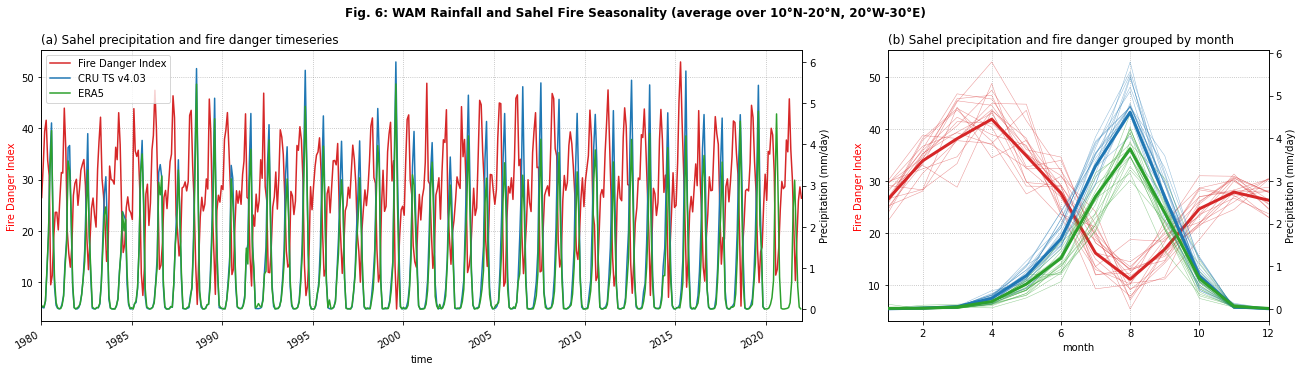

In [6]:
mask_Sahel_IPCC_fire=xr.where((ds_fire.latitude>=bounds_Sahel_IPCC[0]) & (ds_fire.latitude<=bounds_Sahel_IPCC[1]) 
                         & (ds_fire.longitude>=bounds_Sahel_IPCC[2]) & (ds_fire.longitude<=bounds_Sahel_IPCC[3]),1,0)
weights_lat_fire=np.cos(np.deg2rad(ds_fire.latitude))

### Calculate averages for the Sahel region, using the same regional box as in Sec. 2.2: 10°N-20°N, 20°W-30°E
fire_danger_Sahel=ds_fire.fdi.where(mask_Sahel_IPCC_fire).weighted(weights_lat_fire).mean(dim=['longitude','latitude'])
prc_cru_Sahel=ds_cru.pr.where(mask_Sahel_IPCC_cru).weighted(weights_lat_cru).mean(dim=['lon','lat']).sel(time=ds_cru.time.dt.year.isin(np.arange(1980,2021+1,1)))
prc_era_Sahel=ds_era.tp.where(mask_Sahel_IPCC_era).where(mask_landsea).weighted(weights_lat_era).mean(dim=['longitude','latitude']).sel(time=ds_era.time.dt.year.isin(np.arange(1980,2021+1,1)))

### Calculate the mean monthly values from all years of these time series
prc_cru_Sahel_ref=prc_cru_Sahel.groupby('time.month').mean(dim='time')
prc_era_Sahel_ref=prc_era_Sahel.groupby('time.month').mean(dim='time')
fire_danger_Sahel_ref=fire_danger_Sahel.groupby('time.month').mean(dim='time')

fig,axs=plt.subplots(1,2,figsize=(22,5),facecolor='w',gridspec_kw={'width_ratios': [1,0.5]})
ax0_twin=axs[0].twinx()
ax1_twin=axs[1].twinx()

### Plot the timeseries
fire_danger_Sahel.plot(ax=axs[0],c='tab:red',label='Fire Danger Index')
prc_cru_Sahel.plot(ax=ax0_twin,c='tab:blue',label='CRU TS v4.03')
prc_era_Sahel.plot(ax=ax0_twin,c='tab:green',label='ERA5')

### Plot the monthly values for each year
for year in range(2001,2019):
    axs[1].plot(np.arange(1,12+1,1),fire_danger_Sahel.sel(time=fire_danger_Sahel.time.dt.year.isin([year])).values,c='tab:red',lw=0.5,alpha=0.5)
    ax1_twin.plot(np.arange(1,12+1,1),prc_era_Sahel.sel(time=prc_era_Sahel.time.dt.year.isin([year])).values,c='tab:green',lw=0.5,alpha=0.5)
    ax1_twin.plot(np.arange(1,12+1,1),prc_cru_Sahel.sel(time=prc_cru_Sahel.time.dt.year.isin([year])).values,c='tab:blue',lw=0.5,alpha=0.5)
    
### Plot the monthly values averaged over all years
fire_danger_Sahel_ref.plot(ax=axs[1],c='tab:red',lw=3)
prc_cru_Sahel_ref.plot(ax=ax1_twin,c='tab:blue',lw=3,zorder=10)
prc_era_Sahel_ref.plot(ax=ax1_twin,c='tab:green',lw=3,zorder=10)
    
axs[0].set_xlim([datetime.datetime(1980,1,1),datetime.datetime(2022,1,1)])
axs[1].set_xlim([1,12])
    
for aa in axs:
    aa.set_ylabel('Fire Danger Index',color='r')
    aa.grid(color='dimgrey', alpha=0.5, linestyle=':')
for aa in [ax0_twin,ax1_twin]:
    aa.set_ylabel('Precipitation (mm/day)',color='k')
    
fig.suptitle('Fig. 6: WAM Rainfall and Sahel Fire Seasonality (average over 10°N-20°N, 20°W-30°E)',y=1,fontweight='bold')
axs[0].set_title('(a) Sahel precipitation and fire danger timeseries',loc='left')
axs[1].set_title('(b) Sahel precipitation and fire danger grouped by month',loc='left')
 
h, l = axs[0].get_legend_handles_labels()
h2, l2 = ax0_twin.get_legend_handles_labels()
axs[0].legend(h+h2,l+l2)

fig.subplots_adjust(wspace=0.15)

Figure 6 shows that in the Sahel the monsoon rainy season around August (also see [Sec 2.1](#sec2.1)) alternates with a dry season with the highest fire danger around March-April.

As a last step, we would like to test the temporal correlation fire danger and monsoon rainfall. For this, we correlate the JAS monsoon precipitation over West Africa during 1980 to 2020 with the mean fire index during March-April-May of the following dry season. 

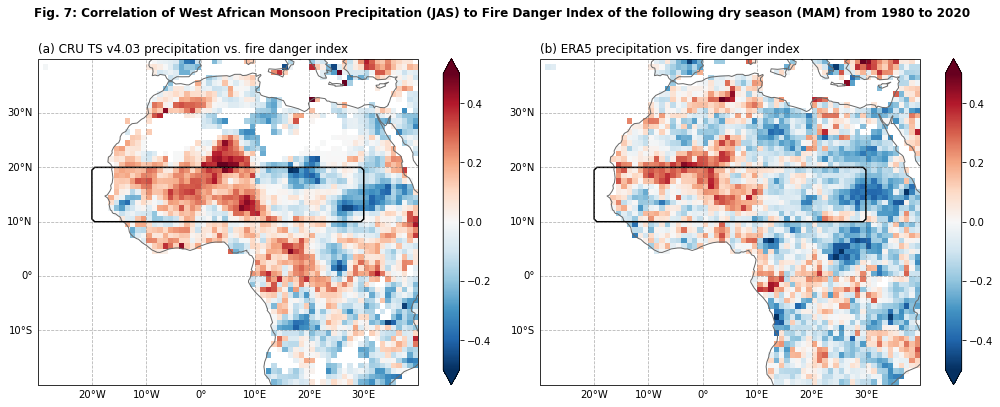

In [7]:
### Calculate the March-April-May mean fire danger index, representing its annual peak (see Fig. 6b)
ds_fire_MAM=ds_fire.sel(time=ds_fire.time.dt.month.isin([2,3,4])).groupby('time.year').mean(dim='time').sel(year=slice(1980,2020))
### Shift fire index time stamp by one year, so that it is compared with the previous monsoon wet season
ds_fire_MAM_shifted=ds_fire_MAM.assign_coords(year=ds_fire_MAM.year.values-1)

### Calculate the Pearson correlation coefficient along the time axis 
corr_cru=xr.corr(prc_JAS_cru,ds_fire_MAM_shifted.fdi.rename(latitude='lat',longitude='lon'),dim='year')
corr_era=xr.corr(prc_JAS_era,ds_fire_MAM_shifted.fdi,dim='year')

fig,axs=plt.subplots(1,2,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(18,6),facecolor='w') 

p0=corr_cru.plot(ax=axs[0],vmin=-0.5,vmax=0.5,cmap='RdBu_r')
p1=corr_era.plot(ax=axs[1],vmin=-0.5,vmax=0.5,cmap='RdBu_r')

for aa in axs:
    aa.coastlines(color='dimgrey')
    aa.set_extent([-30, 40, -20, 40], crs=ccrs.PlateCarree())
    mask_Sahel_IPCC_era.plot.contour(ax=aa,transform=ccrs.PlateCarree(),colors='k',levels=[0.5])

for pp in [p0,p1]:
    gl=pp.axes.gridlines(color='dimgrey', alpha=0.5, linestyle='--',crs=ccrs.PlateCarree(), draw_labels=True)    
    gl.top_labels = False
    gl.right_labels = False
    
fig.suptitle('Fig. 7: Correlation of West African Monsoon Precipitation (JAS) to Fire Danger Index of the following dry season (MAM) from 1980 to 2020',
             y=1,fontweight='bold')
axs[0].set_title('(a) CRU TS v4.03 precipitation vs. fire danger index',loc='left')
axs[1].set_title('(b) ERA5 precipitation vs. fire danger index',loc='left')
    
fig.subplots_adjust(wspace=0)

Figure 7 shows that there seems to be a positive correlation between WAM rainfall and fire danger index in the Sahel, particularly when the CRU TS precipitation data is considered. This means that wildfires were actually promoted after years with amplified monsoon rainfall. A possible explanation is that a stronger WAM increases the biomass available for wildfires during the following dry season [1]. 



# Bibliography <a name="bib"></a>

[1] [N'Datchoh et al. 2015](https://doi.org/10.5194/esd-6-161-2015) Effects of climate variability on savannah fire regimes in West Africa 

[2] [Cook and Vizy 2019](https://doi.org/10.1007/s40641-019-00130-1) Contemporary Climate Change of the African Monsoon Systems 

[3] [Quagraine et al. 2020](https://doi.org/10.3390/cli8100111) West African Summer Monsoon Precipitation Variability as Represented by Reanalysis Datasets 

**IPCC AR6** - [Climate Change 2021](https://www.ipcc.ch/report/sixth-assessment-report-working-group-i/): The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change 
- [4] Ch. 8.3.2.4 "Monsoons" 
- [5] Annex V: Monsoons
- [6] Ch. 10.4.2.1 "The Sahel and West African Monsoon Drought and Recovery"
- [7] Technical Summary, Box TS.13 "Monsoons" 
- [8] Annex VII: Glossary, "Global Monsoon"
- [9] Summary for Policymakers A.3.3 
 
[10] [Wang et al. 2014](https://doi.org/10.5194/cp-10-2007-2014) The global monsoon across timescales - coherent variability of regional monsoons 

[11] [Kitoh et al. 2013](https://doi.org/10.1002/jgrd.50258) Monsoons in a changing world - A regional perspective in a global context 

[12] [Funk et al. 2015](https://link.springer.com/chapter/10.1007/978-3-319-21650-8_8) The East African Monsoon System - Seasonal Climatologies and Recent Variations 

[13] https://www.britannica.com/science/West-African-monsoon 

